In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

## Start

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
# line of best fit
from scipy import signal
# acf and pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# probabity plot
import scipy.stats as scs
# lag plot
from pandas.plotting import lag_plot
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf

In [ ]:
url = '/content/detreded_2.csv'
df = pd.read_csv(url)
df

,observation_date,detrended_2
0,2000-11-01,6.729037
1,2000-12-01,2.577718
2,2001-01-01,2.511962
3,2001-02-01,1.891731
4,2001-03-01,-2.873412
...,...,...
213,2018-08-01,3.495964
214,2018-09-01,5.015853
215,2018-10-01,5.417580
216,2018-11-01,-6.253633


## Split data set


In [ ]:
df.set_index('observation_date', inplace=True)

In [ ]:
# Define sizes for split - 80% for train, 10% each for validation and test
train_size = int(len(df) * 0.6)
validation_size = int(len(df) * 0.2)
test_size = len(df) - train_size - validation_size  # Ensure total coverage

train_set = df[:train_size]
validation_set = df[train_size:train_size + validation_size]
test_set = df[train_size + validation_size:]
train_set.head(5)

,detrended_2
observation_date,
2000-11-01,6.729037
2000-12-01,2.577718
2001-01-01,2.511962
2001-02-01,1.891731
2001-03-01,-2.873412


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['detrended_2'])

# Display the ADF test results in a structured way
print("Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value}")

# Interpretation guidance
print("\nInterpretation:")
print("A p-value below 0.05 indicates that the series is likely stationary (rejects the null hypothesis of non-stationarity).")


Augmented Dickey-Fuller Test Results:
ADF Statistic: -5.485571311838275
p-value: 2.2339864604639756e-06
Critical Values:
	1%: -3.461136478222043
	5%: -2.875078880098608
	10%: -2.5739861168199027

Interpretation:
A p-value below 0.05 indicates that the series is likely stationary (rejects the null hypothesis of non-stationarity).


The detrend_2 is stationary, next make the range to [0,1] for later LSTM

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_set[['detrended_2']])
validation_scaled = scaler.fit_transform(validation_set[['detrended_2']])
test_scaled = scaler.fit_transform(test_set[['detrended_2']])

# convert train_scaled from array into a Pandas Series
train_scaled = pd.Series(train_scaled.flatten(), index=train_set.index)
validation_scaled = pd.Series(validation_scaled.flatten(), index=validation_set.index)
test_scaled = pd.Series(test_scaled.flatten(), index=test_set.index)

# Display the first few rows of the DataFrame
print(f'train_scaled min: {train_scaled.min()}')
print(f'train_scaled max: {train_scaled.max()}')
train_scaled.head(5)

train_scaled min: 0.0
train_scaled max: 1.0


observation_date
2000-11-01    0.689552
2000-12-01    0.642422
2001-01-01    0.641675
2001-02-01    0.634633
2001-03-01    0.580535
dtype: float64

The detrend_2 is stationary, next make the range to [0,1] for later LSTM

## Create features

Use ACF and PACF to determine the optimal lags

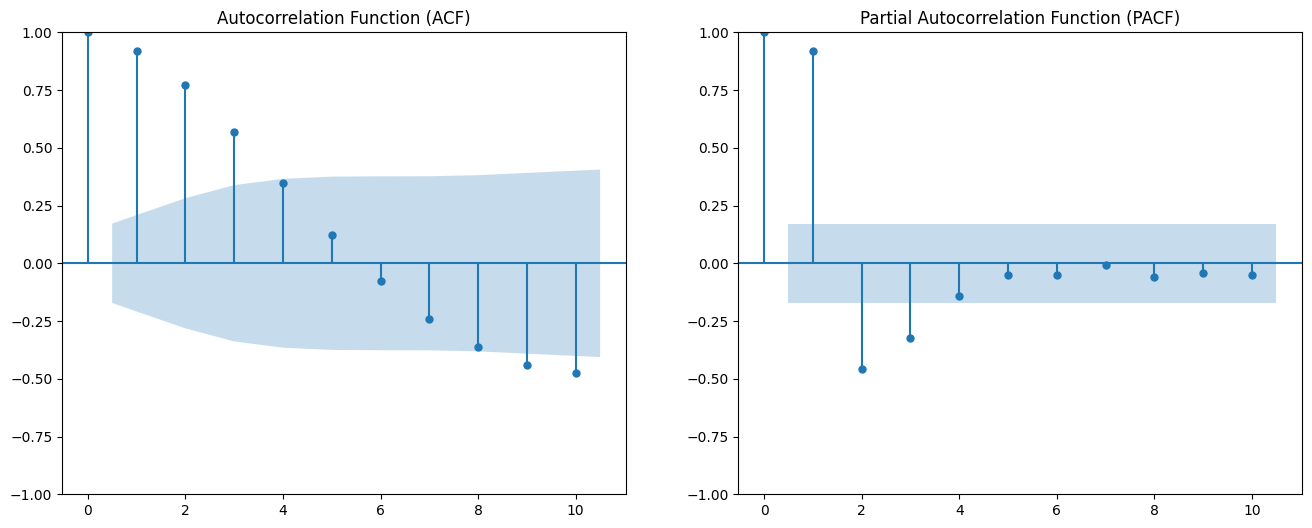

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Autocorrelation Function (ACF) plot
plot_acf(train_scaled, ax=axes[0], lags=10)
axes[0].set_title('Autocorrelation Function (ACF)')

# Partial Autocorrelation Function (PACF) plot
plot_pacf(train_scaled, ax=axes[1], lags=10)
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()


So, the best lag is between 1-3, we will use forward selection to further determine the exact lag number

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np


# Function to generate lag features up to a specified number of lags
def create_lagged_features(series, max_lag):
    df_lags = pd.DataFrame({f'lag_{i}': series.shift(i) for i in range(1, max_lag + 1)})
    df_lags['target'] = series
    return df_lags.dropna()

# Initialize variables
max_lags_to_test = 3
best_num_lags = 0
best_adj_r2 = -np.inf

# Iterate through lags
for lag in range(1, max_lags_to_test + 1):
    # Generate lagged features
    lagged_df = create_lagged_features(train_scaled, lag)

    # Separate predictors and target
    X = lagged_df.drop(columns=['target'])
    y = lagged_df['target']

    # Add constant for OLS regression
    X = sm.add_constant(X)

    # Fit an OLS model
    model = sm.OLS(y, X).fit()

    # Check the adjusted R-squared
    adj_r2 = model.rsquared_adj

    print(f"Lag {lag}: Adjusted R-squared = {adj_r2}")

    # If adjusted R-squared decreases, stop adding lags
    if adj_r2 > best_adj_r2:
        best_num_lags = lag
        best_adj_r2 = adj_r2
    else:
        break

print(f"\nOptimal number of lags based on adjusted R-squared: {best_num_lags}")


Lag 1: Adjusted R-squared = 0.845537857044256
Lag 2: Adjusted R-squared = 0.8847086102270708
Lag 3: Adjusted R-squared = 0.8949899841502764

Optimal number of lags based on adjusted R-squared: 3


In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     359.0
Date:                Thu, 09 May 2024   Prob (F-statistic):           1.23e-60
Time:                        18:52:51   Log-Likelihood:                 196.34
No. Observations:                 127   AIC:                            -384.7
Df Residuals:                     123   BIC:                            -373.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0986      0.021      4.769      0.0

We include lag1, lag2, lag3

In [ ]:
train_scaled_lagged = create_lagged_features(train_scaled, 3)
validation_scaled_lagged = create_lagged_features(validation_scaled, 3)
test_scaled_lagged = create_lagged_features(test_scaled, 3)
train_scaled_lagged.head(5)

,lag_1,lag_2,lag_3,target
observation_date,,,,
2001-02-01,0.641675,0.642422,0.689552,0.634633
2001-03-01,0.634633,0.641675,0.642422,0.580535
2001-04-01,0.580535,0.634633,0.641675,0.560533
2001-05-01,0.560533,0.580535,0.634633,0.568178
2001-06-01,0.568178,0.560533,0.580535,0.553426


In [ ]:
X_train = train_scaled_lagged.drop(columns=['target'])
Y_train = train_scaled_lagged['target']

X_validation = validation_scaled_lagged.drop(columns=['target'])
Y_validation = validation_scaled_lagged['target']

X_test = test_scaled_lagged.drop(columns=['target'])
Y_test = test_scaled_lagged['target']

# Reshape X data for LSTM input
X_train = X_train.values.reshape(-1, 1, 3)  # (samples, timesteps, features)
X_validation = X_validation.values.reshape(-1, 1, 3)
X_test = X_test.values.reshape(-1, 1, 3)

In [ ]:
X_train.shape
# X_train

(127, 1, 3)

## Build LSTM and Train LSTM

In [ ]:
# Create the model

modelName = "LSTM 1"
model = Sequential()
units = 30
data = X_train.copy()

In [ ]:
data.shape[2]

3

In [ ]:
# Add the first LSTM layer input shape, and return sequences
model.add(LSTM(units=units, return_sequences=True, input_shape=(data.shape[1], data.shape[2]), name='LSTM_1'))
# Add dropout to prevent overfitting
model.add(Dropout(0.01))

# Add a second LSTM layer with return sequences
model.add(LSTM(units=int(units), return_sequences=True, name='LSTM_2'))
# Add dropout to prevent overfitting
model.add(Dropout(0.01))

# Add a third LSTM layer with return sequences
model.add(LSTM(units=int(units), return_sequences=True, name='LSTM_3'))

# Add a fourth LSTM layer with return sequences
model.add(LSTM(units=int(units), return_sequences=True, name='LSTM_4'))
# Add dropout to prevent overfitting
model.add(Dropout(0.01))

# Add a fifth LSTM layer
model.add(LSTM(units=int(units), name='LSTM_5'))
# Add dropout to prevent overfitting
model.add(Dropout(0.01))

# Add a dense output layer with one unit
model.add(Dense(units=1, name='Dense_head'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 1, 30)             4080      
                                                                 
 dropout (Dropout)           (None, 1, 30)             0         
                                                                 
 LSTM_2 (LSTM)               (None, 1, 30)             7320      
                                                                 
 dropout_1 (Dropout)         (None, 1, 30)             0         
                                                                 
 LSTM_3 (LSTM)               (None, 1, 30)             7320      
                                                                 
 LSTM_4 (LSTM)               (None, 1, 30)             7320      
                                                                 
 dropout_2 (Dropout)         (None, 1, 30)             0

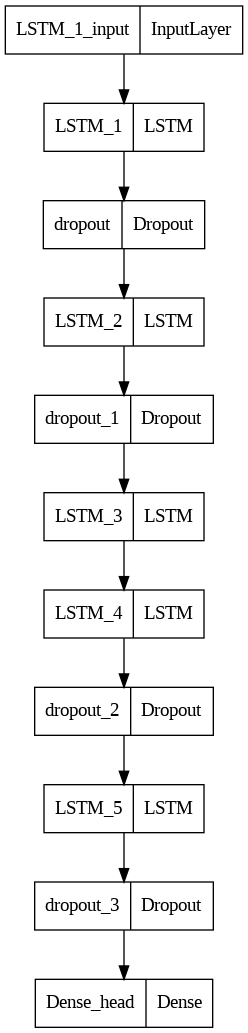

In [ ]:
plot_model(model)

## 2nd

In [ ]:
# Commenting the training cell to speed up notebook. Output pasted in cell below.
# X_validation, X_test, X_train

# # Compile the model
root_mean_squared_error = RootMeanSquaredError()
metrics = [r2_score, root_mean_squared_error]
model.compile(optimizer='adam', loss='mse', metrics=metrics, run_eagerly=True)
# # Save weights only for best model
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min', baseline=None, restore_best_weights=True)
mc = ModelCheckpoint(filepath=modelName + ".ckpt", monitor='val_r2_score', verbose=0, mode='max', save_best_only=True)
max_epochs = 100

# # Fit the model
history = model.fit(X_train, Y_train, epochs=max_epochs, batch_size=32, validation_data=(X_validation, Y_validation), callbacks=[es, mc])

Epoch 1/100


4/4 [==============================] - 22s 5s/step - loss: 0.4351 - r2_score: -21.4800 - root_mean_squared_error: 0.6596 - val_loss: 0.5775 - val_r2_score: -24.7791 - val_root_mean_squared_error: 0.7599
Epoch 2/100
4/4 [==============================] - 32s 11s/step - loss: 0.4204 - r2_score: -16.8502 - root_mean_squared_error: 0.6484 - val_loss: 0.5600 - val_r2_score: -23.9998 - val_root_mean_squared_error: 0.7483
Epoch 3/100
4/4 [==============================] - 15s 5s/step - loss: 0.4048 - r2_score: -24.9903 - root_mean_squared_error: 0.6362 - val_loss: 0.5413 - val_r2_score: -23.1663 - val_root_mean_squared_error: 0.7357
Epoch 4/100
4/4 [==============================] - 17s 6s/step - loss: 0.3879 - r2_score: -17.6830 - root_mean_squared_error: 0.6228 - val_loss: 0.5210 - val_r2_score: -22.2610 - val_root_mean_squared_error: 0.7218
Epoch 5/100
4/4 [==============================] - 22s 7s/step - loss: 0.3695 - r2_score: -16.1037 - root_mean_squared_error: 0.6078 - val_loss: 0.4985

## Compare model performacne in Train and Validation set

In [ ]:
history.history.keys()

dict_keys(['loss', 'r2_score', 'root_mean_squared_error', 'val_loss', 'val_r2_score', 'val_root_mean_squared_error'])

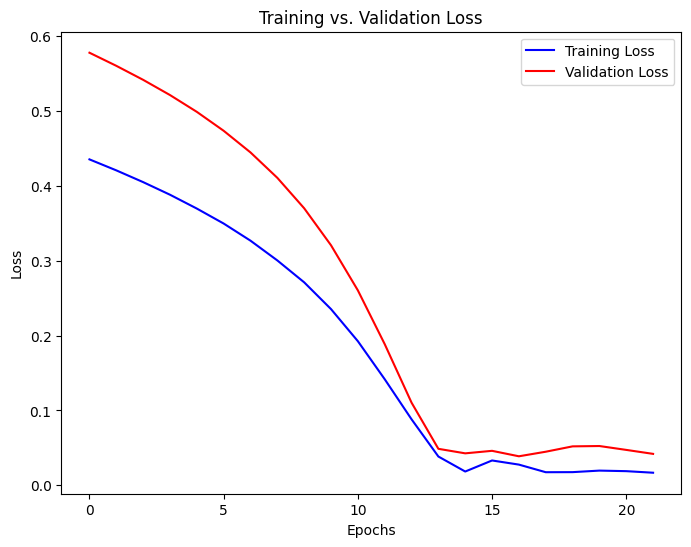

In [ ]:
# loss = history.history['loss']
# epochs = range(len(loss))
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, history.history['loss'], 'r', label='Validation loss')
# plt.title('Training vs Validation loss')
# plt.legend()
# plt.show()


training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(training_loss))

plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
def plot_results(history, metrics):
    # Loss
    loss = history.history['loss']

    epochs = range(len(loss))

    for metric in metrics:
      metric_value = history.history[metric]
      if('val' in metric):
        plt.plot(epochs, metric_value, label="Validation " + metric)
        # plt.title('Validation Results')
      else:
        plt.plot(epochs, metric_value, label="Training " + metric)
        # plt.title('Training Results')
      plt.legend()

    plt.show();

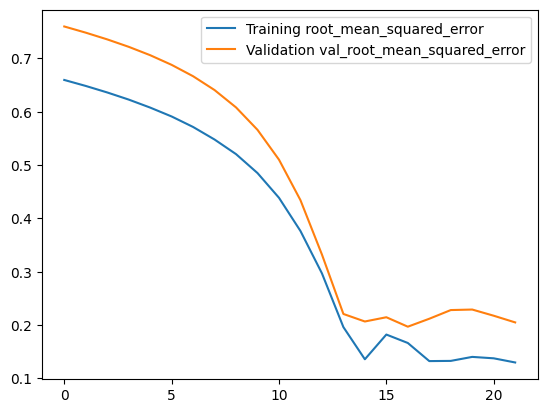

In [ ]:
# RMSE results
plot_results(history, metrics=['root_mean_squared_error', 'val_root_mean_squared_error'])

In [ ]:
val_pred = model.predict(X_validation)

2/2 [==============================] - 0s 45ms/step


In [ ]:
def plot_pred_series(y, yhat):
  plt.figure(figsize=(13,6))
  plt.plot(y, color='red', label='Actual')
  plt.plot(yhat, color='blue', label='Predicted')
  plt.title("Predicted vs. Actual Residuals on Validation Set")
  plt.legend()
  plt.show();

In [ ]:
Y_validation = Y_validation.reset_index(drop=True)

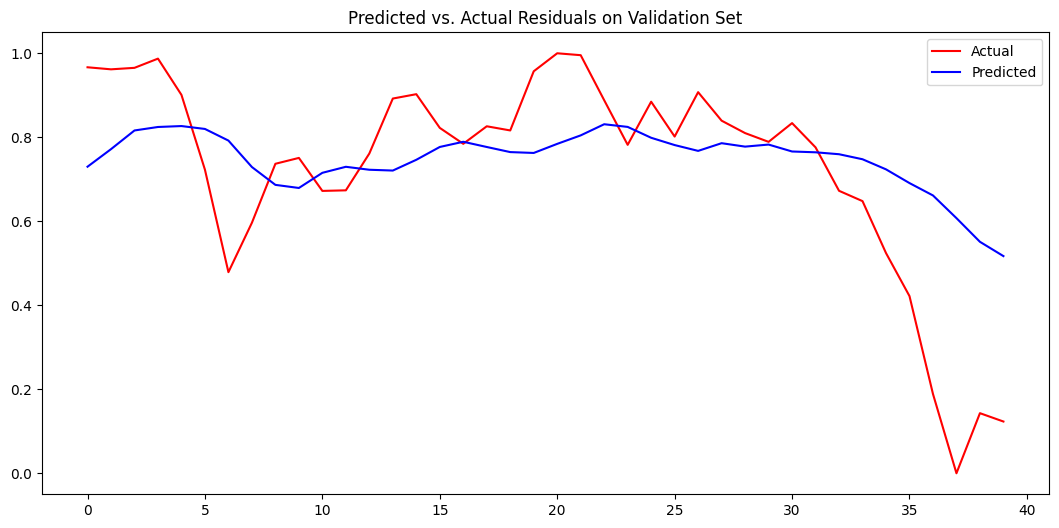

In [ ]:
plot_pred_series(Y_validation, val_pred)

In [ ]:
accuracy = mean_squared_error(Y_validation, val_pred)
score = r2_score(Y_validation, val_pred)
print("########## MSE of testing set ##########")
print(accuracy)
print("########## r2_score of testing set ##########")
print(score)

########## MSE of testing set ##########
0.038804484087672744
########## r2_score of testing set ##########
0.363177865902212


## Compare model performacne between prediction and actual on test set

2/2 [==============================] - 0s 31ms/step


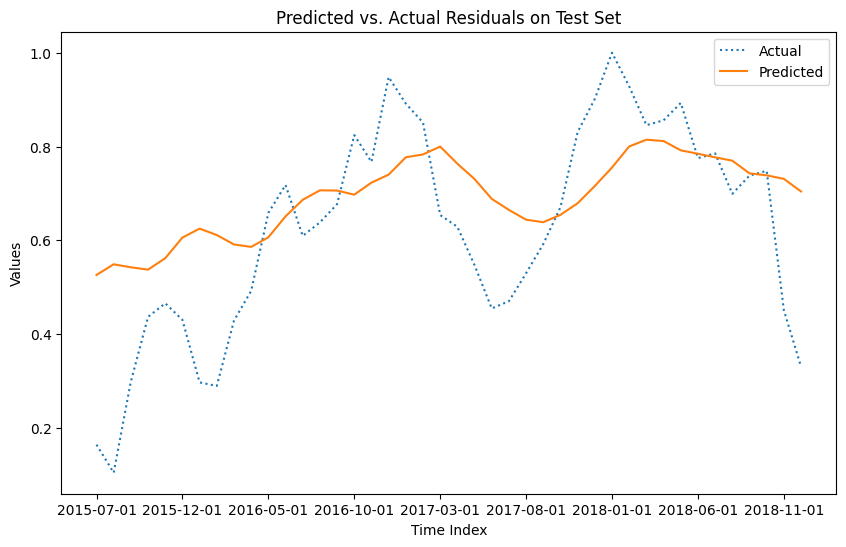

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Predict using the trained model on the test dataset
Y_pred = model.predict(X_test)

# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual', linestyle='dotted')
plt.plot(Y_pred, label='Predicted', linestyle='solid')
plt.legend()
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Predicted vs. Actual Residuals on Test Set')

# Adjust x-axis ticks to show fewer labels and reduce crowding
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))  # Adjust nbins as necessary

plt.show()


In [ ]:
Y_test.index[0]

'2015-07-01'

In [ ]:

# Compute the mean squared error (MSE)
mse_test = mean_squared_error(Y_test, Y_pred)

# Compute the R² score
r2_test = r2_score(Y_test, Y_pred)

# Print the accuracy metrics
print("########## MSE of Test Set ##########")
print(mse_test)
print("########## R² Score of Test Set ##########")
print(r2_test)


########## MSE of Test Set ##########
0.03172244845237673
########## R² Score of Test Set ##########
0.35269305666353323


In [ ]:
# Compute the root mean squared error (MSE)
rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred))

# Print the accuracy metrics
print("########## MSE of Test Set ##########")
print(rmse_test)

########## MSE of Test Set ##########
0.17810796852577013


## add in Attention Net

In [ ]:
pip install keras-self-attention

In [ ]:
# Create the model

modelName = "LSTM 1"
model1 = Sequential()
units = 30
data = X_train.copy()

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras_self_attention import SeqSelfAttention

# Assuming data and units are already defined
model1 = Sequential()

# First LSTM layer
model1.add(LSTM(units=units, return_sequences=True, input_shape=(data.shape[1], data.shape[2]), name='LSTM_1'))
model1.add(Dropout(0.01))

# Second LSTM layer with return sequences and dropout
model1.add(LSTM(units=units, return_sequences=True, name='LSTM_2'))
model1.add(Dropout(0.01))

# Third LSTM layer with return sequences
model1.add(LSTM(units=units, return_sequences=True, name='LSTM_3'))
model1.add(Dropout(0.01))

# Fourth LSTM layer with return sequences and dropout
model1.add(LSTM(units=units, return_sequences=True, name='LSTM_4'))
model1.add(Dropout(0.01))

# Add the attention layer after the last LSTM layer that returns sequences
model1.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model1.add(Dropout(0.01))

# Fifth LSTM layer, does not return sequences
model1.add(LSTM(units=units, return_sequences=False, name='LSTM_5'))
model1.add(Dropout(0.01))

# Output layer
model1.add(Dense(units=1, name='Dense_head'))

# Display model summary
model1.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 1, 30)             4080      
                                                                 
 dropout_10 (Dropout)        (None, 1, 30)             0         
                                                                 
 LSTM_2 (LSTM)               (None, 1, 30)             7320      
                                                                 
 dropout_11 (Dropout)        (None, 1, 30)             0         
                                                                 
 LSTM_3 (LSTM)               (None, 1, 30)             7320      
                                                                 
 dropout_12 (Dropout)        (None, 1, 30)             0         
                                                                 
 LSTM_4 (LSTM)               (None, 1, 30)            

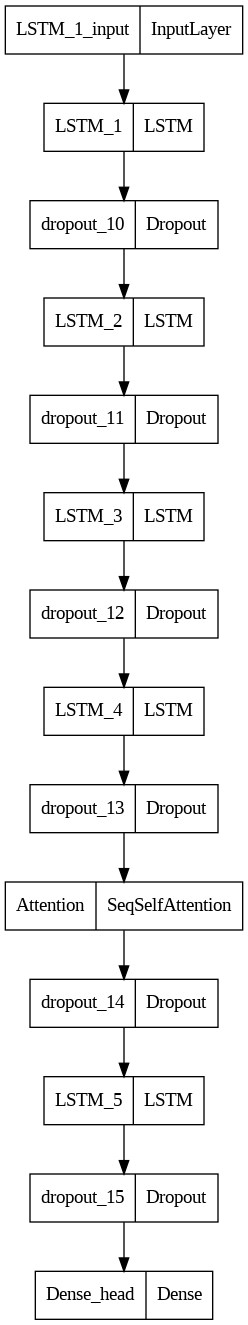

In [ ]:
plot_model(model1)

In [ ]:
# Commenting the training cell to speed up notebook. Output pasted in cell below.
# X_validation, X_test, X_train

# # Compile the model
root_mean_squared_error = RootMeanSquaredError()
metrics = [r2_score, root_mean_squared_error]
model1.compile(optimizer='adam', loss='mse', metrics=metrics, run_eagerly=True)
# # Save weights only for best model
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min', baseline=None, restore_best_weights=True)
mc = ModelCheckpoint(filepath=modelName + ".ckpt", monitor='val_r2_score', verbose=0, mode='max', save_best_only=True)
max_epochs = 100

# # Fit the model
history = model1.fit(X_train, Y_train, epochs=max_epochs, batch_size=32, validation_data=(X_validation, Y_validation), callbacks=[es, mc])

Epoch 1/100
4/4 [==============================] - 17s 5s/step - loss: 0.4350 - r2_score: -16.5462 - root_mean_squared_error: 0.6596 - val_loss: 0.5771 - val_r2_score: -24.7644 - val_root_mean_squared_error: 0.7597
Epoch 2/100
4/4 [==============================] - 17s 5s/step - loss: 0.4198 - r2_score: -29.2931 - root_mean_squared_error: 0.6479 - val_loss: 0.5593 - val_r2_score: -23.9701 - val_root_mean_squared_error: 0.7479
Epoch 3/100
4/4 [==============================] - 16s 5s/step - loss: 0.4040 - r2_score: -24.4546 - root_mean_squared_error: 0.6356 - val_loss: 0.5403 - val_r2_score: -23.1211 - val_root_mean_squared_error: 0.7350
Epoch 4/100
4/4 [==============================] - 15s 5s/step - loss: 0.3867 - r2_score: -18.5546 - root_mean_squared_error: 0.6219 - val_loss: 0.5197 - val_r2_score: -22.2039 - val_root_mean_squared_error: 0.7209
Epoch 5/100
4/4 [==============================] - 15s 5s/step - loss: 0.3681 - r2_score: -24.0383 - root_mean_squared_error: 0.6067 - val_l

In [ ]:
! pip install keras_self_attention

In [ ]:
history.history.keys()

dict_keys(['loss', 'r2_score', 'root_mean_squared_error', 'val_loss', 'val_r2_score', 'val_root_mean_squared_error'])

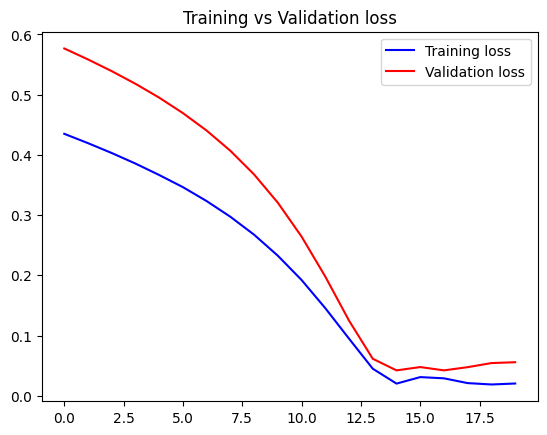

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training vs Validation loss')
plt.legend()
plt.show()

In [ ]:
def plot_results(history, metrics):
    # Loss
    loss = history.history['loss']

    epochs = range(len(loss))

    for metric in metrics:
      metric_value = history.history[metric]
      if('val' in metric):
        plt.plot(epochs, metric_value, label="Validation " + metric)
        # plt.title('Validation Results')
      else:
        plt.plot(epochs, metric_value, label="Training " + metric)
        # plt.title('Training Results')
      plt.legend()

    plt.show();

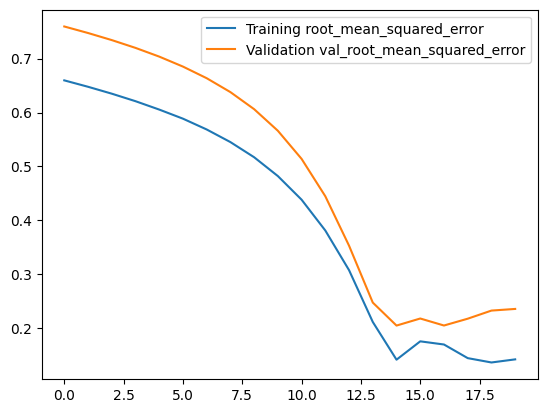

In [ ]:
# RMSE results
plot_results(history, metrics=['root_mean_squared_error', 'val_root_mean_squared_error'])

In [ ]:
val_pred = model1.predict(X_validation)

2/2 [==============================] - 0s 104ms/step


In [ ]:
def plot_pred_series(y, yhat):
  plt.figure(figsize=(13,6))
  plt.plot(y, color='red', label='Actual')
  plt.plot(yhat, color='blue', label='Predicted')
  plt.title("Actual vs Predicted Residual ")
  plt.legend()
  plt.show();

In [ ]:
Y_validation = Y_validation.reset_index(drop=True)

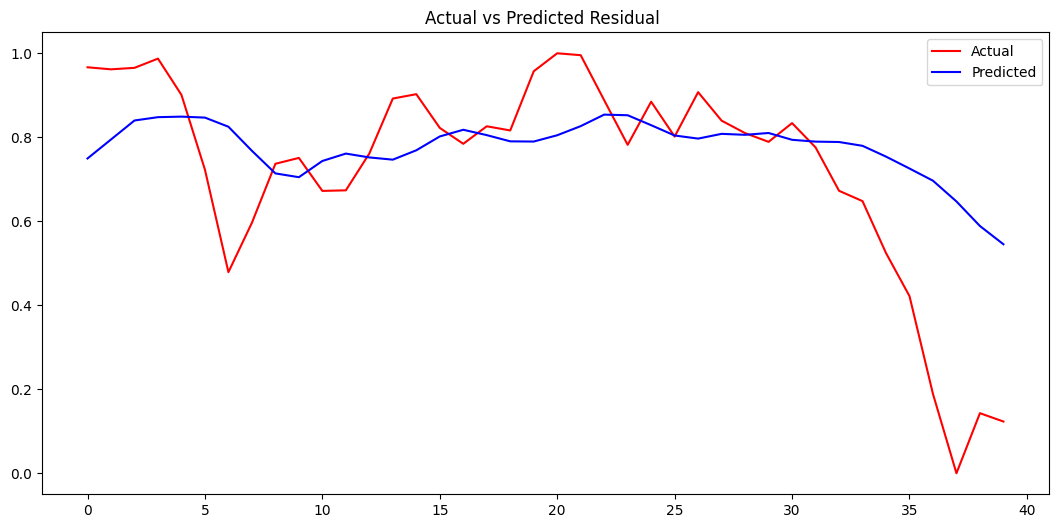

In [ ]:
plot_pred_series(Y_validation, val_pred)

In [ ]:
accuracy = mean_squared_error(Y_validation, val_pred)
score = r2_score(Y_validation, val_pred)
print("########## MSE of testing set ##########")
print(accuracy)
print("########## r2_score of testing set ##########")
print(score)

########## MSE of testing set ##########
0.04207993237984299
########## r2_score of testing set ##########
0.30942433662363455


## Test Set

2/2 [==============================] - 0s 37ms/step


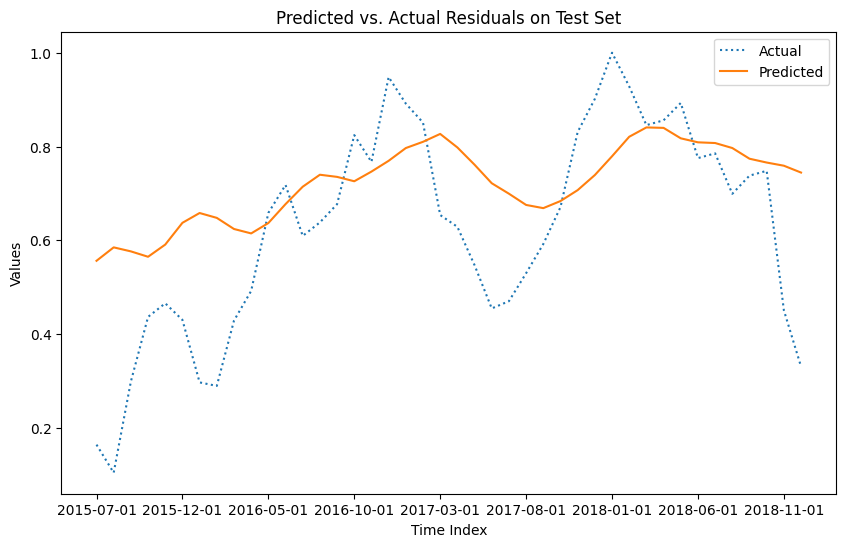

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Predict using the trained model on the test dataset
Y_pred = model1.predict(X_test)

# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual', linestyle='dotted')
plt.plot(Y_pred, label='Predicted', linestyle='solid')
plt.legend()
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Predicted vs. Actual Residuals on Test Set')

# Adjust x-axis ticks to show fewer labels and reduce crowding
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))  # Adjust nbins as necessary

plt.show()


In [ ]:
# Compute the root mean squared error (MSE)
rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred))

# Print the accuracy metrics
print("########## MSE of Test Set ##########")
print(rmse_test)

########## MSE of Test Set ##########
0.19330511584236823


## Transformer + Attention Net + LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from torch.utils.data import DataLoader, TensorDataset


In [ ]:
from keras.layers import Layer
import keras.backend as K
import numpy as np

class PositionEncoding(Layer):
    def __init__(self, max_len=500, **kwargs):
        super(PositionEncoding, self).__init__(**kwargs)
        self.max_len = max_len

    def build(self, input_shape):
        d_model = input_shape[-1]
        pe = np.zeros((self.max_len, d_model))
        position = np.arange(0, self.max_len).reshape(-1, 1)
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.pe = K.variable(pe, dtype=K.floatx())
        super(PositionEncoding, self).build(input_shape)

    def call(self, x):
        seq_len = K.shape(x)[1]
        return x + self.pe[:seq_len, :]

    def compute_output_shape(self, input_shape):
        return input_shape




In [ ]:
# Create the model

modelName = "LSTM 1"
model2 = Sequential()
units = 30
data = X_train.copy()

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, MultiHeadAttention, LayerNormalization, Dropout, Dense

# model2 = Sequential()
# # Input shape: (batch_size, sequence_length, feature_dim)
# model2.add(LSTM(units=units, return_sequences=True, input_shape=(data.shape[1], data.shape[2]), name='LSTM_1'))

# # Transformer block
# model2.add(MultiHeadAttention(num_heads=8, key_dim=64, name='MultiAttention_1'))  # Multi-head attention layer
# model2.add(Dropout(0.1))
# model2.add(LayerNormalization(epsilon=1e-6))

# model2.add(Dense(units=units, activation='relu', name='FeedForward_1'))  # Feed-forward layer
# model2.add(Dropout(0.1))
# model2.add(LayerNormalization(epsilon=1e-6))

# # Second LSTM layer with return sequences and dropout
# model2.add(LSTM(units=units, return_sequences=True, name='LSTM_2'))
# model2.add(Dropout(0.01))

# # Third LSTM layer with return sequences
# model2.add(LSTM(units=units, return_sequences=True, name='LSTM_3'))

# # Fourth LSTM layer with return sequences and dropout
# model2.add(LSTM(units=units, return_sequences=True, name='LSTM_4'))
# model2.add(Dropout(0.01))

# # Add the attention layer after the last LSTM layer that returns sequences
# model2.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))

# # Fifth LSTM layer, does not return sequences
# model2.add(LSTM(units=units, return_sequences=False, name='LSTM_5'))

# # Output layer
# model2.add(Dense(units=1, name='Dense_head'))
# # model2.add(Dense(1, activation='linear'))  # Output layer

# # Display model summary
# model2.summary()

In [ ]:
! pip install keras_self_attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=8701232d1fa5a676de01beb4ba0186cb8fe1ade0786cdff005a5eb77b060f6ab
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, MultiHeadAttention, LayerNormalization, Dropout, Dense
from keras_self_attention import SeqSelfAttention

# Define the number of units
sequence_length = data.shape[1]  # Define sequence length from your data

# Define the input layer
inputs = Input(shape=(sequence_length, data.shape[2]))

# First LSTM layer
x = LSTM(units=units, return_sequences=True, name='LSTM_1')(inputs)

# Prepare query, key, value for MultiHeadAttention
query = x  # In some cases, you might want to project this with a Dense layer
key = query
value = query

# Transformer block
attention_output = MultiHeadAttention(num_heads=8, key_dim=64, name='MultiAttention_1')(query, key, value)
attention_output = Dropout(0.1)(attention_output)
attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
attention_output = Dense(units=units, activation='relu', name='FeedForward_1')(attention_output)
attention_output = Dropout(0.1)(attention_output)
x = LayerNormalization(epsilon=1e-6)(attention_output)

# Continuing with LSTM layers
x = LSTM(units=units, return_sequences=True, name='LSTM_2')(x)
x = Dropout(0.01)(x)
x = LSTM(units=units, return_sequences=True, name='LSTM_3')(x)
x = LSTM(units=units, return_sequences=True, name='LSTM_4')(x)
x = Dropout(0.01)(x)

# # Add the attention layer after the last LSTM layer that returns sequences
# x = SeqSelfAttention(attention_activation='sigmoid', name='Attention')(x)

# Fifth LSTM layer, does not return sequences
x = LSTM(units=units, return_sequences=False, name='LSTM_5')(x)

# Output layer
outputs = Dense(units=1, name='Dense_head')(x)

# Build the model
model2 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

# Display model summary
model2.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1, 3)]               0         []                            
                                                                                                  
 LSTM_1 (LSTM)               (None, 1, 30)                4080      ['input_2[0][0]']             
                                                                                                  
 MultiAttention_1 (MultiHea  (None, 1, 30)                63006     ['LSTM_1[0][0]',              
 dAttention)                                                         'LSTM_1[0][0]',              
                                                                     'LSTM_1[0][0]']              
                                                                                            

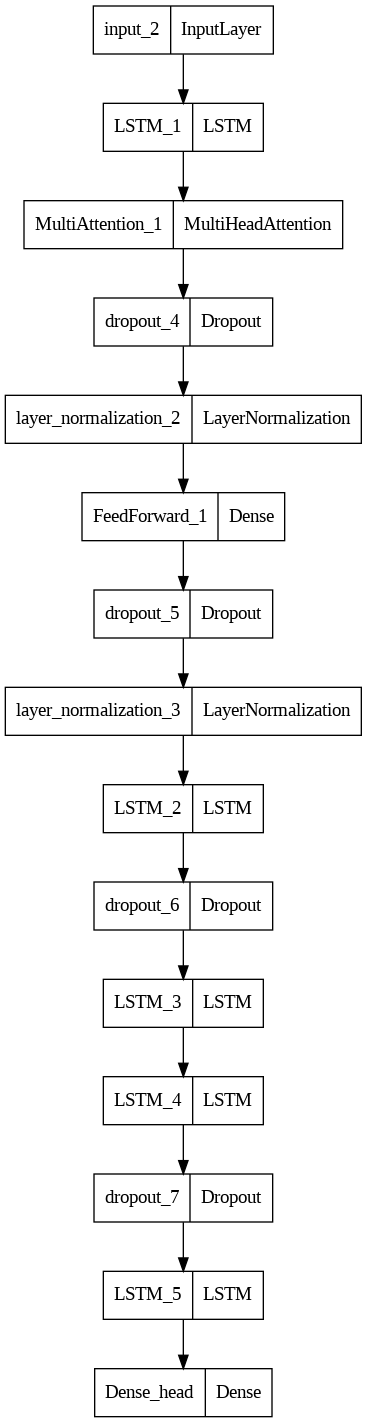

In [ ]:
plot_model(model2)

In [ ]:
# # Compile the model
root_mean_squared_error = RootMeanSquaredError()
metrics = [r2_score, root_mean_squared_error]
model2.compile(optimizer='adam', loss='mse', metrics=metrics, run_eagerly=True)
# # Save weights only for best model
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min', baseline=None, restore_best_weights=True)
mc = ModelCheckpoint(filepath=modelName + ".ckpt", monitor='val_r2_score', verbose=0, mode='max', save_best_only=True)
max_epochs = 100

# # Fit the model
history = model2.fit(X_train, Y_train, epochs=max_epochs, batch_size=5, validation_data=(X_validation, Y_validation), callbacks=[es, mc])

Epoch 1/100


26/26 [==============================] - 33s 925ms/step - loss: 0.3805 - r2_score: -48.6931 - root_mean_squared_error: 0.6169 - val_loss: 0.4037 - val_r2_score: -169.1184 - val_root_mean_squared_error: 0.6354
Epoch 2/100
26/26 [==============================] - 23s 900ms/step - loss: 0.1202 - r2_score: -26.6062 - root_mean_squared_error: 0.3467 - val_loss: 0.0592 - val_r2_score: -14.8971 - val_root_mean_squared_error: 0.2433
Epoch 3/100
26/26 [==============================] - 25s 957ms/step - loss: 0.0257 - r2_score: -0.8734 - root_mean_squared_error: 0.1603 - val_loss: 0.0499 - val_r2_score: -11.3333 - val_root_mean_squared_error: 0.2234
Epoch 4/100
26/26 [==============================] - 8s 310ms/step - loss: 0.0168 - r2_score: -0.6152 - root_mean_squared_error: 0.1297 - val_loss: 0.0299 - val_r2_score: -12.3623 - val_root_mean_squared_error: 0.1730
Epoch 5/100
26/26 [==============================] - 29s 1s/step - loss: 0.0134 - r2_score: -1.2916 - root_mean_squared_error: 0.1158 

In [ ]:
history.history.keys()

dict_keys(['loss', 'r2_score', 'root_mean_squared_error', 'val_loss', 'val_r2_score', 'val_root_mean_squared_error'])

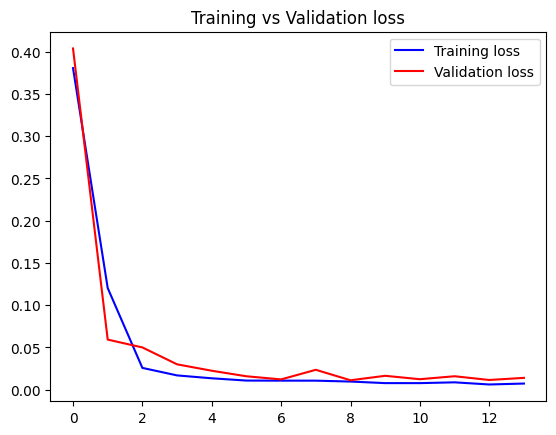

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training vs Validation loss')
plt.legend()
plt.show()

In [ ]:
def plot_results(history, metrics):
    # Loss
    loss = history.history['loss']

    epochs = range(len(loss))

    for metric in metrics:
      metric_value = history.history[metric]
      if('val' in metric):
        plt.plot(epochs, metric_value, label="Validation " + metric)
        # plt.title('Validation Results')
      else:
        plt.plot(epochs, metric_value, label="Training " + metric)
        # plt.title('Training Results')
      plt.legend()

    plt.show();

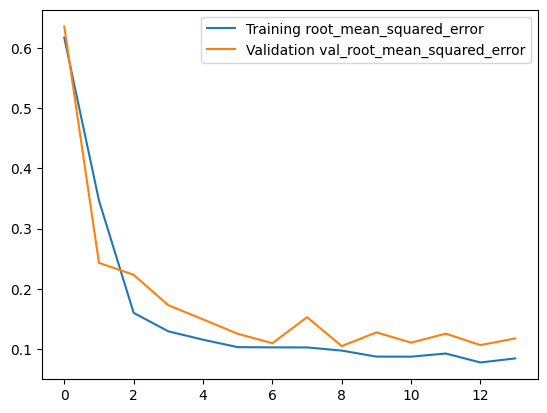

In [ ]:
# RMSE results
plot_results(history, metrics=['root_mean_squared_error', 'val_root_mean_squared_error'])

In [ ]:
val_pred = model2.predict(X_validation)

2/2 [==============================] - 0s 105ms/step


In [ ]:
def plot_pred_series(y, yhat):
  plt.figure(figsize=(13,6))
  plt.plot(y, color='red', label='Actual')
  plt.plot(yhat, color='blue', label='Predicted')
  plt.title("Actual vs Predicted Residuals ")
  plt.legend()
  plt.show();

In [ ]:
Y_validation = Y_validation.reset_index(drop=True)

In [ ]:
val_pred = np.squeeze(val_pred)
val_pred.shape

(40,)

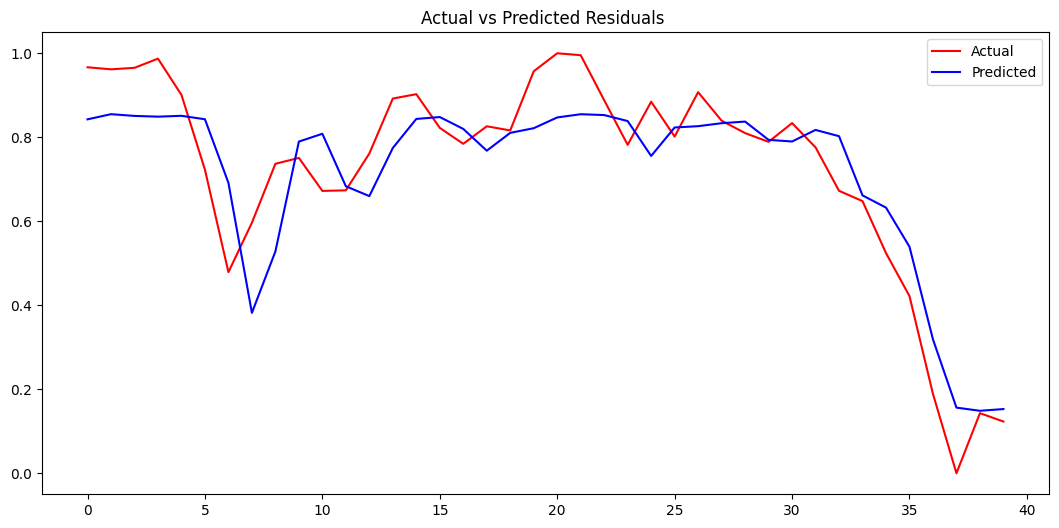

In [ ]:
plot_pred_series(Y_validation, val_pred)

In [ ]:
accuracy = mean_squared_error(Y_validation, val_pred)
score = r2_score(Y_validation, val_pred)
print("########## MSE of testing set ##########")
print(accuracy)
print("########## r2_score of testing set ##########")
print(score)

########## MSE of testing set ##########
0.011064662886950283
########## r2_score of testing set ##########
0.8184173195855299


## Test Set

2/2 [==============================] - 0s 156ms/step


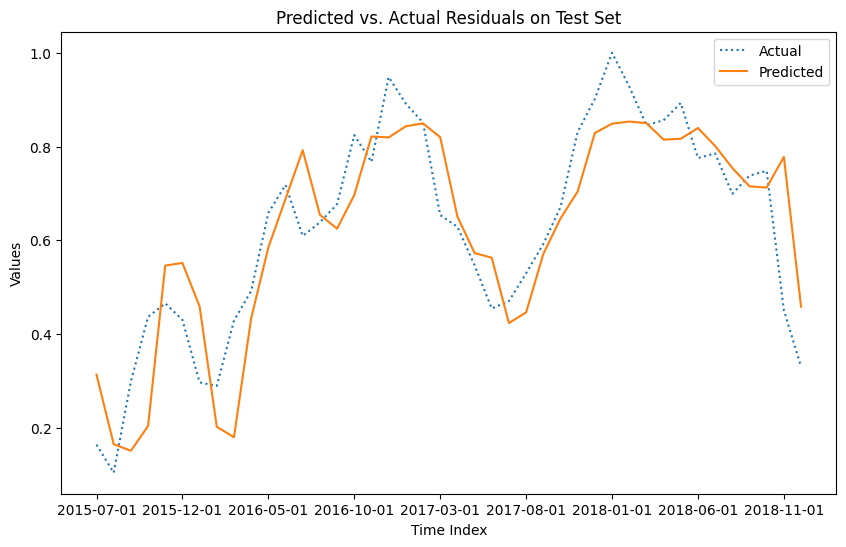

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Predict using the trained model on the test dataset
Y_pred = model2.predict(X_test)

# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual', linestyle='dotted')
plt.plot(Y_pred, label='Predicted', linestyle='solid')
plt.legend()
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Predicted vs. Actual Residuals on Test Set')

# Adjust x-axis ticks to show fewer labels and reduce crowding
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))  # Adjust nbins as necessary

plt.show()


In [ ]:
# Compute the root mean squared error (MSE)
rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred))

# Print the accuracy metrics
print("########## MSE of Test Set ##########")
print(rmse_test)

########## MSE of Test Set ##########
0.11373128704532579
